<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/orso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orso's live

Make our bear Orso find all the honey in his home turf choosing the most convenient path.  

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/images/Orso.png?raw=1'>
<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/images/turf.png?raw=1'>

https://opendatascience.com/bears-need-to-learn-as-well-practical-reinforcement-learning-with-tensorflow-2-0-tf-agents

# Hands-On: Run this notebook and watch the agent (Orso) learn
* Jump to this cell https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/orso.ipynb#scrollTo=_fHrBrxxI5Rt
* Run all the cells above (Runtime->Run All Before)
* Execute all the cells below by clicking shift+return one by one
* look at Orso move in this new world
* Stop when you reach the cell that starts the training https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/orso.ipynb#scrollTo=OS3pnnbAI5R9&line=3&uniqifier=1
* full training of the agent can take up to 25 minutes
  * so you are advised to reduce the number of iterations to 100 or even 50 (from 500)
  * note that depending on how your world looks like and for how long you train, you might not get good results
* while the training is running watch how the graphs evolve and make sense out of it
* answer the questions below

## Questions:
* Why is the bear sometimes not ending up in its cave?
* Why is the position of the honey pots constantly changing in the state plot (the one on the right)?
* Is there any relation between the sum of rewards and number of steps?
* Can you make sense of all the other plots?
* Why do you get a negative reward at the beginning?
* How good do you think the reward can get?
* What is a good number of steps?

### Install gym, tensorflow, tf-agents,..., setup display

In [1]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 9)
# mpl.rcParams["figure.dpi"] = 300

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q easyagents 2>/dev/null
    !pip install -q networkx==2.3.0 2>/dev/null

     |████████████████████████████████| 71kB 2.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.5MB 10.0MB/s 
     |████████████████████████████████| 839kB 54.9MB/s 
     |████████████████████████████████| 327kB 47.8MB/s 
     |████████████████████████████████| 1.6MB 57.1MB/s 
     |████████████████████████████████| 86.3MB 50kB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 13.1MB 39.9MB/s 
     |████████████████████████████████| 3.3MB 62.2MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.0MB 60.0MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 450kB 56.1MB/s 
     |████████████████████████████████| 3.8MB 55.4MB/s 
     |████████████████████████████████| 1.8MB 3.2MB/s 


In [3]:
import easyagents
easyagents.__version__

'1.5.0'

In [4]:
import tensorflow as tf
tf.__version__

'2.0.1'

In [5]:
import tensorflow_probability as tfp
tfp.__version__

'0.8.0'

In [6]:
import tf_agents
tf_agents.__version__

'0.3.0'

##### suppress package warnings, in colab: load additional packages for rendering

In [7]:
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

## Define Gym Environment

In [8]:
import gym
from gym.utils import seeding
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random

In [9]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13,
        'P': 14,
        'Q': 15,
        'R': 16,
        'T': 17,
        'U': 18,
        'V': 19,
        'W': 20,
        'X': 21,
        'Y': 22,
        'Z': 23
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O',
        14: 'P',
        15: 'Q',
        16: 'R',
        17: 'T',
        18: 'U',
        19: 'V',
        20: 'W',
        21: 'X',
        22: 'Y',
        23: 'Z'
    }
    return state_map[state_as_int]

In [10]:
# * Each row defines one location in Orso's world
# * S stands for start and is the cave Orso lives in
# * Each location has access to up to 4 other locations defined in each row
# * Each connection is attributed with a value which is the cost of traveling the connection
# * You can change this graph in the first hands-on of this notebook described later in this notebook 
# * Anything preceded by the \# is a comment

graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
# this is how you could add a new node (make sure to remove N and O node above)
            # 'N': [('M', 100), ('O', 100), ('Z', 100)],
            # 'O': [('N', 100), ('G', 300), ('Z', 300)],
            # 'Z': [('O', 300), ('N', 100)]
        }

### Orso's Environment (OpenAI Gym)

In [11]:
class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/jupyter_notebooks/images/"
        self.image_orso = mpi.imread(base + "Orso.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        source = self.state

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": source, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    # each node gets a reward, either 0 or 10000
    def modulate_reward(self):
        self.customer_reward = {}

        node_names = list(self.map.keys())
        # initialize all nodes with 0
        for node_name in node_names:
            self.customer_reward[node_name] = 0

        # 10000 rewards are only at a few random places
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self._honeypot_places = []

        # starting from 1, not 0, so that 'S' (position of the cave) never gets a reward 
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        for sample in samples:
            self.customer_reward[node_names[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [node_names[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for action, (target, cost) in enumerate(connections):
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                directed_label = str(source) + ":" + str(action)
                existing_edge = nx_graph.get_edge_data(source, target)
                if existing_edge is not None: 
                    directed_label = str(existing_edge['label']) + ' - ' + directed_label
                nx_graph.add_edge(source, target, color=color, weight=6, cost=cost, label=directed_label, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self, render_graph_labels=False, render_costs=False):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure()
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]

        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edges=edges, edge_color=edge_colors, width=edge_weights, with_labels=render_graph_labels)

        if render_graph_labels:
          edge_labels = [self.nx_graph[u][v]['label'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_labels))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        if render_costs:
          edge_costs = [self.nx_graph[u][v]['cost'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_costs))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.node[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human', render_graph_labels=False, render_costs=False):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure(render_graph_labels=render_graph_labels, render_costs=render_costs)
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

# Start paying attention starting from here on


In [12]:
env = OrsoEnv()

In [13]:
env.reset()

array([    0.,  -300.,   900.,  -200., -1000.,     0.,     0.,  1000.,
           0.,     0.,     0.,  1000.,  1000.,     0.,  1000.,  1000.,
        1000.,     0.,     0.])

## observation the agent will see
a flat vector consisting of
1. position of bear
1. 4 combined rewards (cost of travel plus potential honey reward) of the four paths the bear can choose
1. 14 values for each node, 1000 if there still is honey there, 0 otherwise

_this additional semantic information is only available to us, not to the learning algorithm, it only sees a flat vector of numbers_

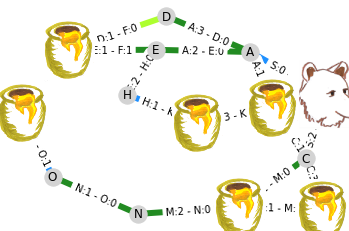

In [14]:
env.render(render_graph_labels=True)

### after each step in a certain directon we get
1. the new observation
1. the reward for this step/action normalized to 1
1. if the game is done (bear needs to collect all honey and return to its cave)
1. additional information

In [15]:
observation, reward, done, info = env.step(1)
observation, reward, done, info

(array([   2., -100., -100.,  -50.,  800.,    0.,    0.,    0.,    0.,
           0.,    0., 1000., 1000.,    0., 1000., 1000., 1000.,    0.,
           0.]), 0.15, False, {'from': 'S', 'to': 'B'})

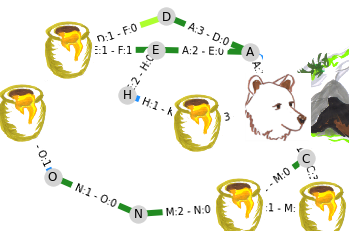

In [16]:
env.render(render_graph_labels=True)

### Let's see how a random policy moves our dear Orso

CPU times: user 1min 3s, sys: 36.9 s, total: 1min 39s
Wall time: 58.1 s


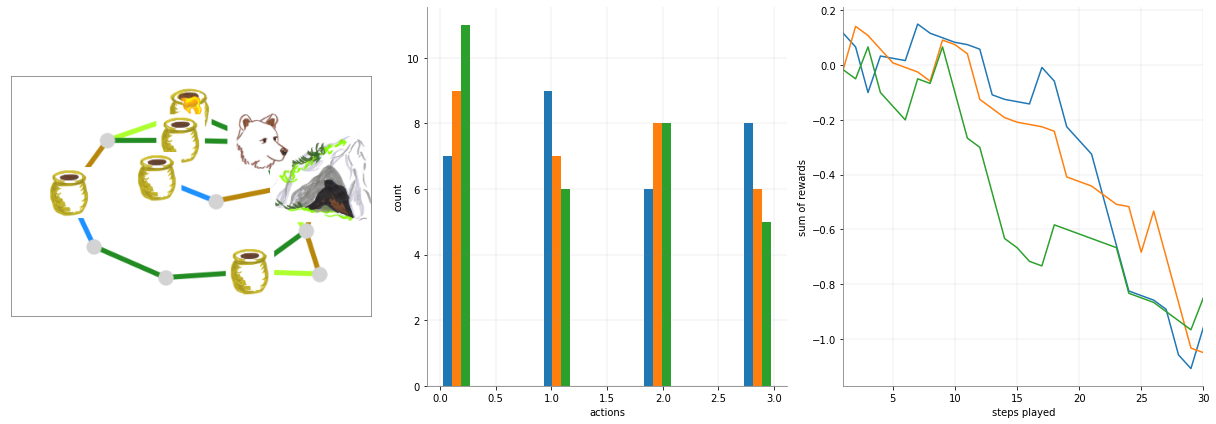

In [17]:
%%time

from easyagents.env import register_with_gym
from easyagents.agents import RandomAgent
from easyagents.callbacks import plot
      
env_name="Orso-v1"
register_with_gym(gym_env_name=env_name, entry_point=OrsoEnv, max_episode_steps=1000)

rndAgent = RandomAgent(gym_env_name='Orso-v1')
rndAgent.play([plot.State(),plot.Actions(), plot.StepRewards()], num_episodes=3, max_steps_per_episode=30)

### Each policy can be evaluated by playing a number of games

In [18]:
metrics = rndAgent.evaluate(max_steps_per_episode=30)
metrics.rewards.mean, metrics.steps.mean

(-1.3203333333333334, 29.78)

# Train policy with tfagents PpoAgent


CPU times: user 22min 11s, sys: 2min 27s, total: 24min 38s
Wall time: 16min 56s


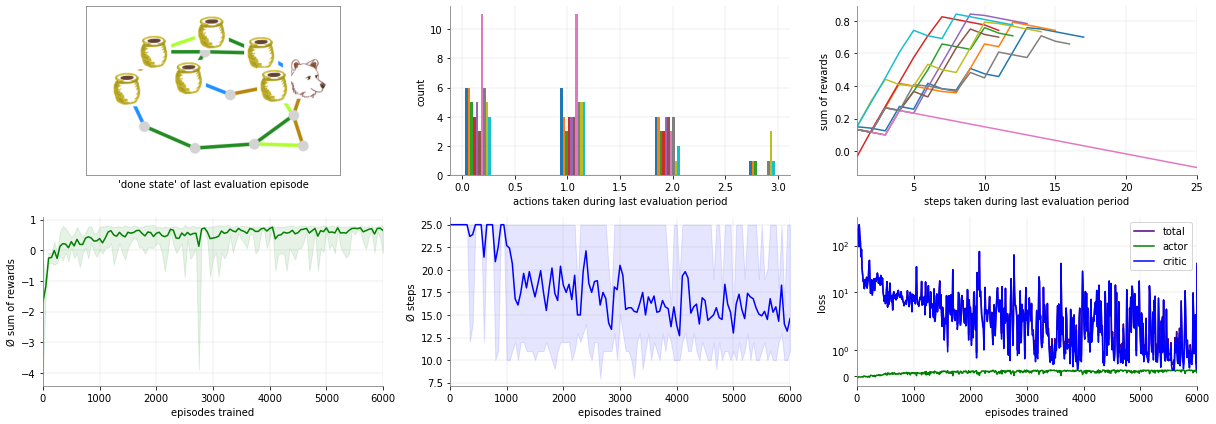

In [19]:
%%time

from easyagents.agents import PpoAgent

register_with_gym(gym_env_name=env_name, entry_point=OrsoEnv, max_episode_steps=1000)
ppoAgent = PpoAgent(gym_env_name=env_name, fc_layers=(500,500,500))

plots = [plot.State(), 
         plot.Actions(), 
         plot.StepRewards(), 
         plot.Rewards(), 
         plot.Steps(), 
         plot.Loss(),
         plot.ToMovie()]
ppoAgent.train(plots, 
               learning_rate=1e-4,
               num_iterations = 600, 
               num_episodes_per_iteration = 10,
               max_steps_per_episode = 25)

In [20]:
metrics = ppoAgent.evaluate(num_episodes=10)
metrics.rewards.min, metrics.rewards.mean, metrics.rewards.max, metrics.steps.min, metrics.steps.mean, metrics.steps.max

(-0.5166666666666666, 0.4958333333333332, 0.7749999999999998, 13, 21.9, 50)

## Our Observations

* Note from the histogram that Orso initially is stuck with action 0. As the training proceeds the other actions are also discovered, resulting on average in shorter episodes and more rewards. 
* Also the state plot (rendering the state of the last evaluation episodes last step) shows that Orso starts to find more honey pots on its way back home. 
* Note that action 3 is less likely than the other actions. That's because we only have a few positions with 3 or more valid directions but all positions have at least 2 directions.

## Play - see the bear cruise his turf (turn ouput into a movie)

In [21]:
# ppoAgent.play([plot.State(), plot.StepRewards(num_steps_between_plot=1), plot.Actions(), plot.ToMovie(fps=3)], 
#               num_episodes=5, max_steps_per_episode=20)
ppoAgent.play([plot.State(), plot.ToMovie(fps=3)], 
              num_episodes=1, max_steps_per_episode=20);

## Advanced experiments
1. Lazy Orso: so far with every step our bear needs to move
   * Additional action zero: do nothing
   * Will this result in the bear not leaving his cave any more? 
1. No punishment for invalid action
   * Does this change anything?